In [237]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import scipy.stats as stats
from scipy.special import inv_boxcox
import json
import joblib
import warnings
warnings.filterwarnings("ignore") 

In [241]:
# Configuration
loc = "/Users/kirannagarkoti15/Documents/VSCode/End-End Linear Regression- Car Price Prediction/"

## Load Dataset


In [242]:
data = pd.read_csv(loc + r"raw/car data.csv")

## Exploratory Data Analysis (EDA)

In [197]:
# Display the first few rows
data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [198]:
data.shape

(301, 9)

In [199]:
# Basic Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [200]:
# Checking missing values
data.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [201]:
# Check statistical summary
data.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [202]:
# Check unique values in categorical columns
for col in ['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']:
    print(f"\nUnique values in {col}: {data[col].nunique()}")


Unique values in Car_Name: 98

Unique values in Fuel_Type: 3

Unique values in Seller_Type: 2

Unique values in Transmission: 2

Unique values in Owner: 3


In [203]:
# Car_Name contains 98 unique categories, and this number of categories is very high, we'll drop it
data.drop(columns=['Car_Name'], inplace=True)

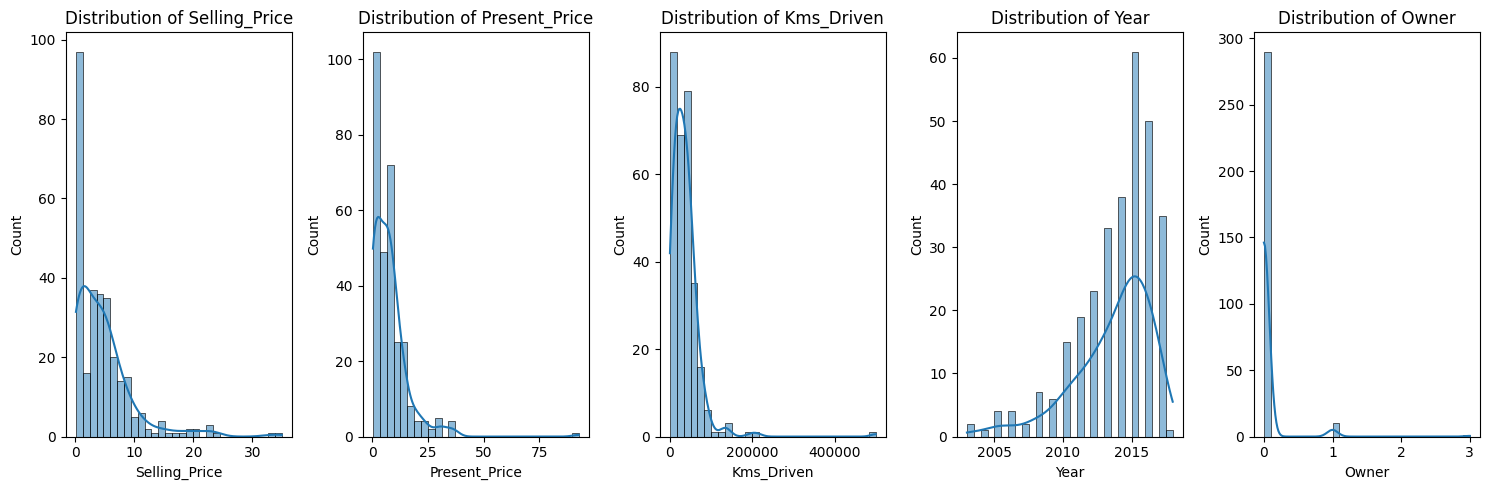

In [204]:
# Univariate analysis- Numerical variables
numeric_features = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Year', 'Owner']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(15, 5))
for i, feature in enumerate(numeric_features):
    sns.histplot(data[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

Variables are either right or left skewed but normal

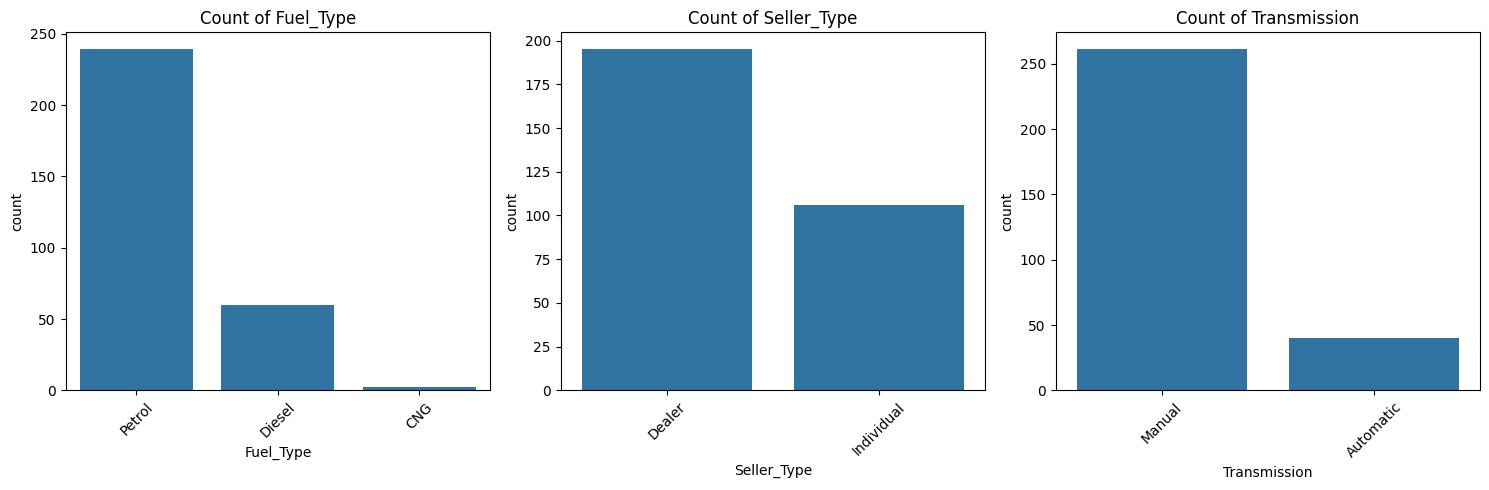

In [205]:
# Univariate analysis- Categorical variables
categorical_features = ['Fuel_Type', 'Seller_Type', 'Transmission']

fig, axes = plt.subplots(1, len(categorical_features), figsize=(15, 5))
for i, feature in enumerate(categorical_features):
    sns.countplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f"Count of {feature}")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

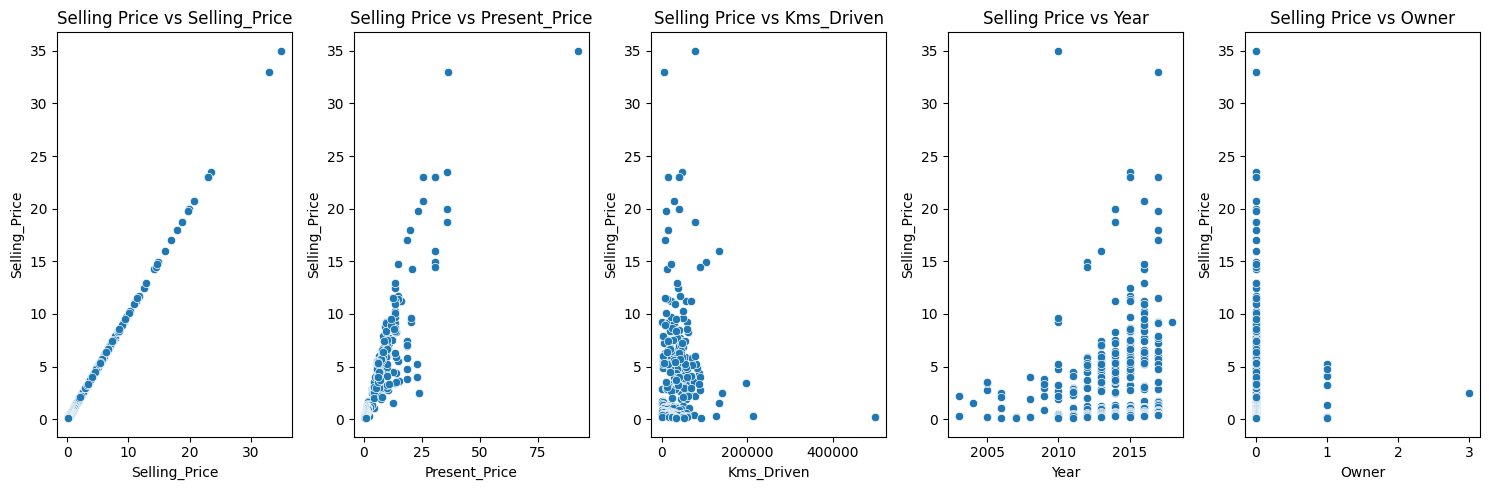

In [206]:
# Bivariate analysis- Target vs Numerical vriables
fig, axes = plt.subplots(1, len(numeric_features), figsize=(15, 5))
for i, feature in enumerate(numeric_features):
    sns.scatterplot(x=data[feature], y=data['Selling_Price'], ax=axes[i])
    axes[i].set_title(f"Selling Price vs {feature}")
plt.tight_layout()
plt.show()


### **Conclusion**
##### -As Present_Price increases, Selling_Price increases as well. So Selling_Price is directly proportional to Present_Price.
##### -As the car's Kms_Driven increases, its Selling_Price decreases. So Selling_Price is inversely proportional to Kms_Driven.
##### -As the Year increases, its Selling_Price increases. So Selling_Price is directly proportional to the year car was bought i.e newer the car better the price.
##### -As the number of previous car owners increases, its Selling_Price decreases. So Selling_Price is inversely proportional to Owner.

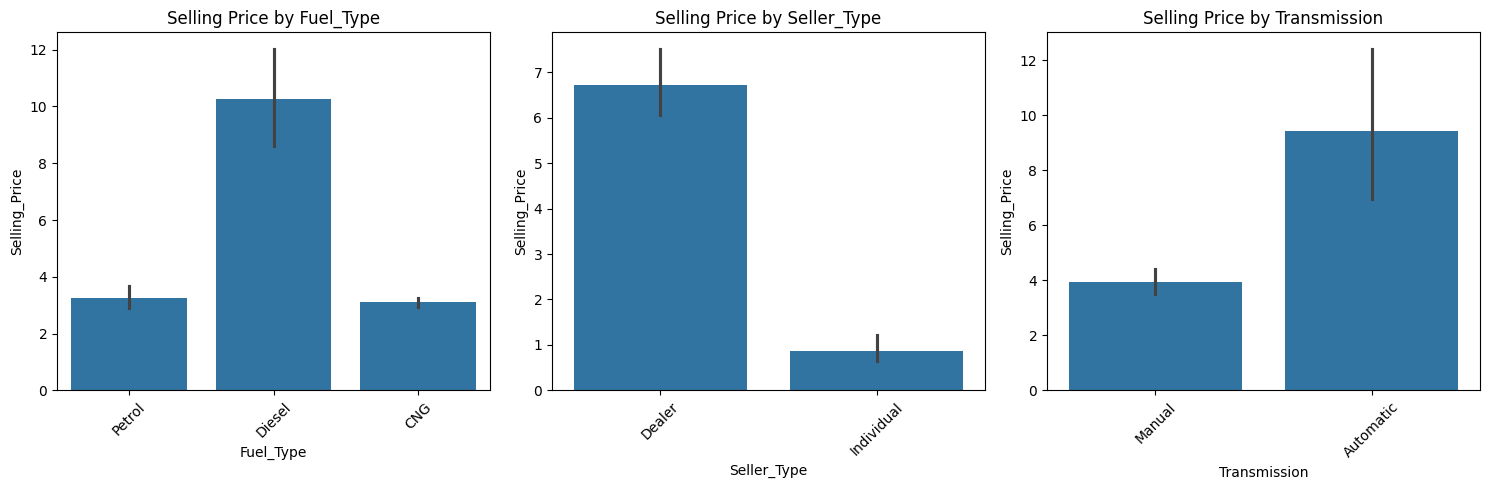

In [207]:
# Bivariate analysis- Target vs Categorical vriables
fig, axes = plt.subplots(1, len(categorical_features), figsize=(15, 5))
for i, feature in enumerate(categorical_features):
    sns.barplot(x=data[feature], y=data['Selling_Price'], ax=axes[i])
    axes[i].set_title(f"Selling Price by {feature}")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

### **Conclusion**
##### -Diesel cars have highest selling price
##### -The Selling_Price of cars sold by individuals is lower than the price of cars sold by dealers.
##### -Automatic cars are more expensive than manual cars.

## Feature Engineering

In [208]:
# Convert categorical variables to numerical using OneHotEncoding
data = pd.get_dummies(data, columns=['Fuel_Type', 'Seller_Type', 'Transmission'], drop_first=True)

In [209]:
# Create a new feature: Car Age using Year
curr_year = datetime.now().year
data['Car_Age'] = curr_year - data['Year']
data.drop(columns=['Year'], inplace=True)  # Drop redundant columns

## Data Preprocessing

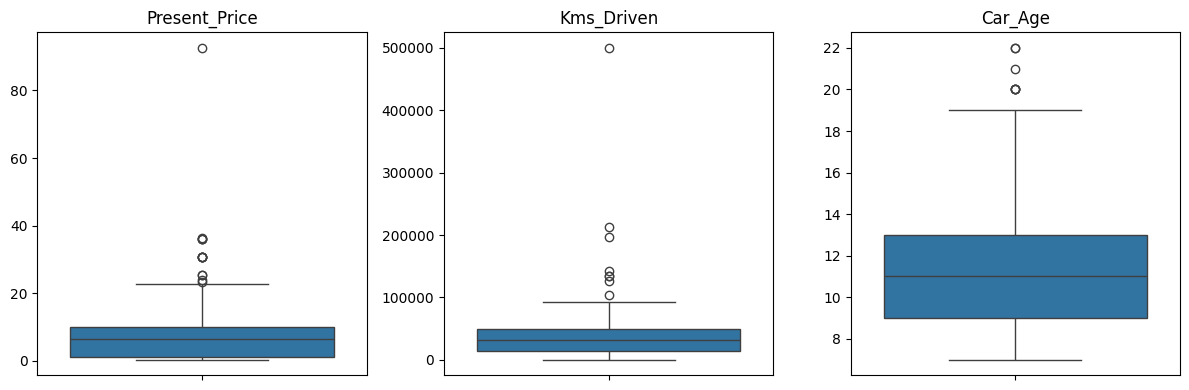

In [210]:
# Plot boxplots for all numerical columns, to detect outliers
numeric_features = ['Present_Price', 'Kms_Driven', 'Car_Age']

# Set up subplots (1 row, multiple columns)
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(12, 4))

# Loop through each feature and create a boxplot
for i, feature in enumerate(numeric_features):
    sns.boxplot(data=data[feature], ax=axes[i])
    axes[i].set_title(f"{feature}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [211]:
# outlier detection/removal from numeric columns
Q1 = data[numeric_features].quantile(0.25)
Q3 = data[numeric_features].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds, removing extreme outliers as df is small
lower_bound = Q1 - 3* IQR
upper_bound = Q3 + 3* IQR

# Create a boolean mask for non-outliers
mask = ~((data[numeric_features] < lower_bound) | (data[numeric_features] > upper_bound)).any(axis=1).astype(bool)

# Apply the mask to filter the dataset
data = data[mask]


In [212]:
data.shape

(296, 9)

Removed 5 observations from the dataset condering those as extreme outliers.

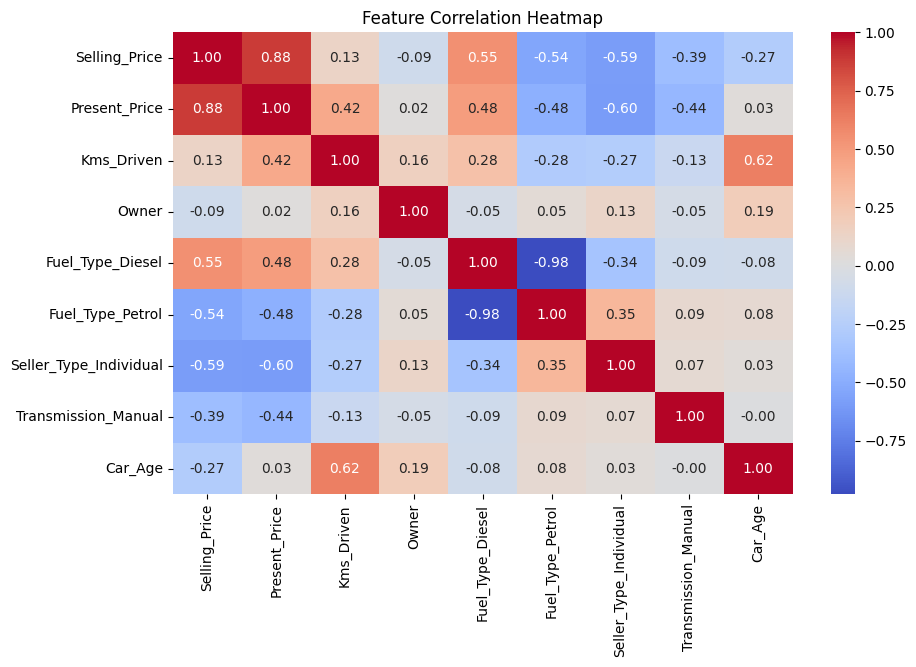

In [213]:
# Checking correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [214]:
# dropping Fuel_Type_Petrol as it is highly correlated with Fuel_Type_Diesel
data.drop(columns=['Fuel_Type_Petrol'], inplace=True)


## Train-Test Split

In [215]:
# Define Independent (X) and Dependent (Y) variables
X = data.drop(columns=['Selling_Price'])
y = data['Selling_Price']

In [216]:
# Splitting into Train and Test Set (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [217]:
# Standardizing the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training

In [218]:
# Train Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [220]:
# Get coefficients and intercept
intercept = lr.intercept_
coefficients = lr.coef_

# Display the equation
equation = f"Y = {intercept:.4f}"
for i, col in enumerate(X.columns):
    equation += f" + ({coefficients[i]:.4f} * {col})"
    
print("Linear Regression Equation:")
print(equation)


Linear Regression Equation:
Y = 4.4037 + (3.7874 * Present_Price) + (-0.9670 * Kms_Driven) + (-0.1571 * Owner) + (0.8144 * Fuel_Type_Diesel) + (-0.3799 * Seller_Type_Individual) + (-0.1319 * Transmission_Manual) + (-0.6629 * Car_Age)


In [221]:
# Predictions
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

## Model Evaluation

In [222]:
# Function to evaluate the model
def evaluate_model(y_true, y_pred, dataset_type="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n {dataset_type} Set Performance:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.2f}")

In [223]:
# Evaluate on Train and Test Data
evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_test, y_test_pred, "Test")


 Train Set Performance:
Mean Absolute Error (MAE): 1.05
Mean Squared Error (MSE): 2.16
Root Mean Squared Error (RMSE): 1.47
R-squared (R²): 0.90

 Test Set Performance:
Mean Absolute Error (MAE): 1.04
Mean Squared Error (MSE): 2.06
Root Mean Squared Error (RMSE): 1.44
R-squared (R²): 0.88


In [224]:
# Model Summary using Statsmodels
X_train_const = sm.add_constant(X_train_scaled)  # Add constant term
model = sm.OLS(y_train, X_train_const).fit()
print("\nLinear Regression Model Summary:")
print(model.summary())


Linear Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:          Selling_Price   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     283.2
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          1.15e-108
Time:                        19:51:35   Log-Likelihood:                -425.91
No. Observations:                 236   AIC:                             867.8
Df Residuals:                     228   BIC:                             895.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4

## Checking Linear Regression Assumptions
### We need to check the assumptions of linear regression, because if the assumptions are not met, the interpretation of the results will not always be valid:



##### 1. Linearity Assumption: There should be a linear relationship between the independent variables (X) and the dependent.
##### How to check: Plot Actual vs. Predicted Values for the training set. If the relationship is linear, points should align along a straight  diagonal line.
##### If violated: Try log transformation of the target variable or Use Polynomial Regression for non-linear relationships or Switch to a non-linear model like Decision Trees or Random Forest.

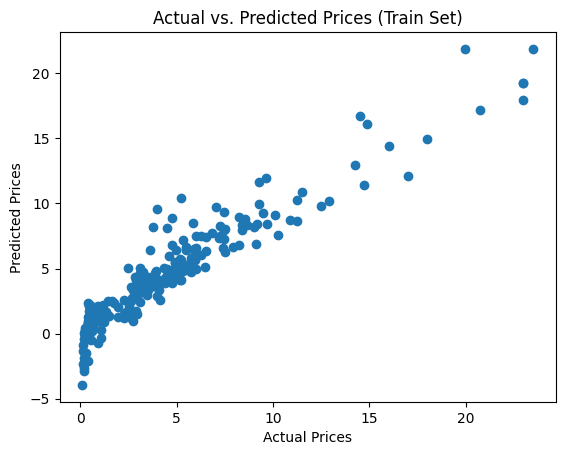

In [225]:
# 1.Linearity Assumption
plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices (Train Set)")
plt.show()

***The inspection of the plot shows that the linearity assumption is somewhat satisfied.***

##### 2. Normality of Residuals (Errors): Residuals (errors) should follow a normal distribution (bell-shaped curve). This ensures valid hypothesis testing.
##### How to check: Plot a histogram or KDE plot of residuals.
##### If violated: Apply log transformation or Box-Cox transformation on Y or try a different regression model.

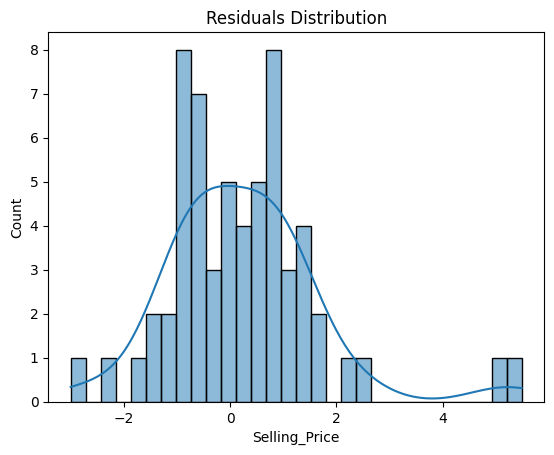

In [226]:
# 2.Normality of Residuals
residuals = y_test - y_test_pred
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.show()

***The inspection of the plot shows that the normality assumption is somewhat satisfied.***

##### 3. Homoscedasticity (Constant Variance of Residuals): The spread of residuals should be constant across all values of the predicted price. If variance changes (e.g., increasing funnel shape), it indicates heteroscedasticity.
##### How to check: Plot Predicted Values vs. Residuals.
##### If violated: Try log transformation on the dependent variable.

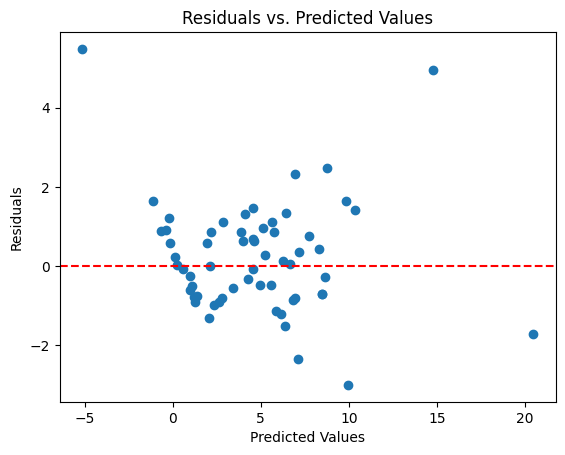

In [227]:
# 3.Homoscedasticity (Constant Variance of Residuals)
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

***The inspection of the plot shows that the homoscedasticity assumption is not satisfied.***

##### 4. Multicollinearity Check (VIF - Variance Inflation Factor): Predictor variables should not be highly correlated with each other. High multicollinearity reduces model interpretability.
##### How to check: Compute VIF (Variance Inflation Factor) for each independent variable. If VIF > 10: Remove highly correlated variables.
##### If violated: Remove one of the highly correlated features or use Principal Component Analysis (PCA) to reduce dimensions or apply Ridge or Lasso Regression to reduce multicollinearity effects.

In [228]:
# 4.Multicollinearity Check (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
                  Feature       VIF
0           Present_Price  2.702545
1              Kms_Driven  2.396170
2                   Owner  1.108703
3        Fuel_Type_Diesel  1.435886
4  Seller_Type_Individual  1.741503
5     Transmission_Manual  1.363637
6                 Car_Age  1.909779


***We had already removed two highly correlated variables, so VIF looks good signifying no multicollinearity***

##### 5. No Autocorrelation (Durbin-Watson Test): Residuals should not be correlated across observations. Autocorrelation is common in time-series data, where errors in one period affect future periods.
##### How to check: Use the Durbin-Watson Test. DW ~ 2 → No autocorrelation, DW < 1 or DW > 3 → Autocorrelation exists 
##### If violated: Use Time-Series models like ARIMA instead of Linear Regression, include lagged variables in the model.

In [229]:
# 5.No Autocorrelation (Durbin-Watson Test)
dw_test = durbin_watson(residuals)
print("Durbin-Watson Test Statistic:", dw_test)

Durbin-Watson Test Statistic: 1.9215286900140263


***DW ~2 signifying no autocorrelation***

### Applying Box-Cox transformation on whole dataset

In [230]:
# In order to satisfy the regression assumptions, we apply the Box-Cox transformation on the whole dataset. 
# The Box-Cox transformations change the shape of our data, making it more close to a normal distribution.

In [231]:
# numerical Columns in the dataset
numerical_features = ['Present_Price', 'Kms_Driven', 'Owner', 'Car_Age']

# Initialize a dictionary to store lambda values
fitted_lambda = pd.Series(np.zeros(len(numerical_features), dtype=np.float64), index=numerical_features)


# Apply Box-Cox transformation on target variable (Selling_Price)
y_train, fitted_lambda['Selling_Price'] = stats.boxcox(y_train + 0.1)

# Apply Box-Cox transformation to numerical features in X_train
for col in X_train.columns:
    X_train[col], fitted_lambda[col] = stats.boxcox(X_train[col] + 1)

# Apply the same Box-Cox transformation to test set using the stored lambda values
y_test = stats.boxcox(y_test + 0.1, fitted_lambda['Selling_Price'])
for col in X_test.columns:
    X_test[col] = stats.boxcox(X_test[col] + 1, fitted_lambda[col])

# Convert transformed target variables to DataFrames
y_train = pd.DataFrame(y_train, index=X_train.index, columns=['Selling_Price'])
y_test = pd.DataFrame(y_test, index=X_test.index, columns=['Selling_Price'])

# Combine transformed train & test data
X_boxcox = pd.concat([X_train, X_test])
y_boxcox = pd.concat([y_train, y_test])

# Final transformed dataset
df_boxcox = pd.concat([X_boxcox, y_boxcox], axis=1)
df_boxcox.sort_index(inplace=True)

# Display first few rows of transformed data
df_boxcox.head()

,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,Car_Age,Selling_Price
0,2.000099,194.483029,0.0,0.00000,0.0,224.971743,0.805307,1.365175
1,2.535667,238.790460,0.0,0.13231,0.0,224.971743,0.809431,1.788918
2,2.569238,106.205085,0.0,0.00000,0.0,224.971743,0.786831,2.337359
3,1.725097,93.607747,0.0,0.00000,0.0,224.971743,0.815904,1.177767
4,2.200699,237.439923,0.0,0.13231,0.0,224.971743,0.805307,1.748891


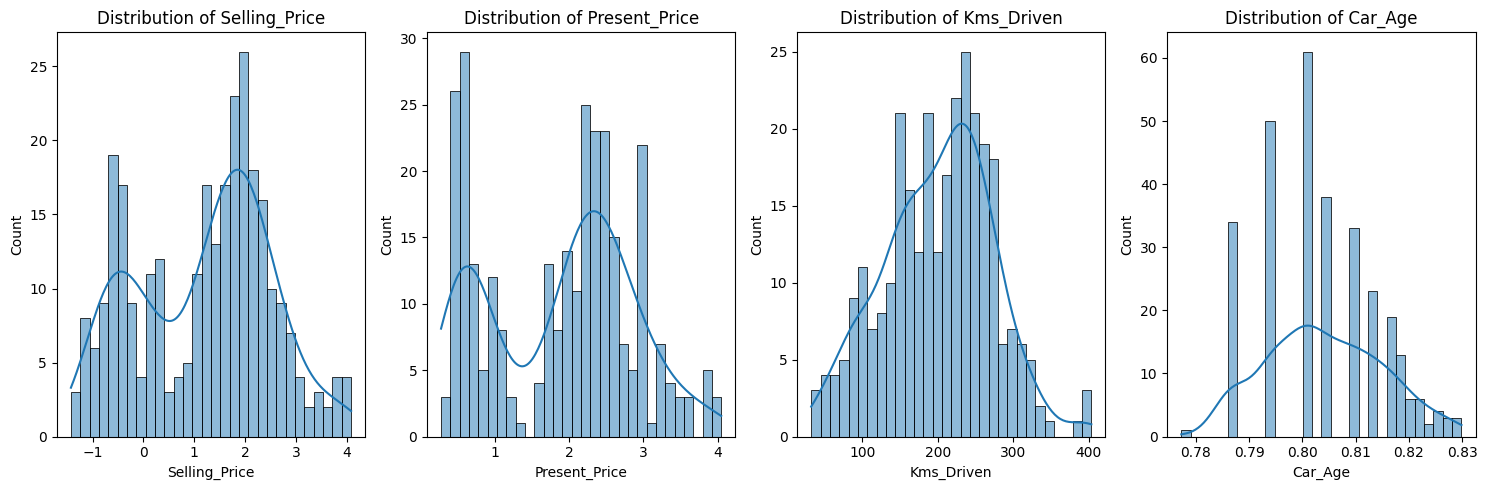

In [232]:
# Univariate analysis- Numerical variables
numeric_features = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Car_Age']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(15, 5))
for i, feature in enumerate(numeric_features):
    sns.histplot(df_boxcox[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

After box-cox transformation, numeric features are normally distributed which were not earlier.

********************************************** Building a new model on df_boxcox **********************************************

In [233]:
## Train-Test Split on new df- df_boxcox
# Step 1: Define features and target
X = df_boxcox.drop(columns=['Selling_Price'])  # Features
y = df_boxcox['Selling_Price']  # Target variable

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# Step 3: Standardization (Optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Training

In [234]:
# Train Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [236]:
# Get coefficients and intercept
intercept = lr.intercept_
coefficients = lr.coef_

# Display the equation
equation = f"Y = {intercept:.4f}"
for i, col in enumerate(X.columns):
    equation += f" + ({coefficients[i]:.4f} * {col})"
    
print("Linear Regression Equation:")
print(equation)

Linear Regression Equation:
Y = 1.1479 + (1.0866 * Present_Price) + (-0.1156 * Kms_Driven) + (-0.0300 * Owner) + (0.1286 * Fuel_Type_Diesel) + (-0.1863 * Seller_Type_Individual) + (0.0167 * Transmission_Manual) + (-0.2670 * Car_Age)


# Interpretation of Linear Regression Equation  

**Equation:**  
Y = 1.1479 + (1.0866 * Present_Price) + (-0.1156 * Kms_Driven) + (-0.0300 * Owner) + (0.1286 * Fuel_Type_Diesel) + (-0.1863 * Seller_Type_Individual) + (0.0167 * Transmission_Manual) + (-0.2670 * Car_Age)  

## **Interpretation of Each Term**  

- **Intercept (1.1479):** Baseline selling price when all features are zero (may not be realistic).  
- **Present_Price (1.0866):** Selling price increases by 1.0866 units for every 1-unit increase in Present_Price.  
- **Kms_Driven (-0.1156):** More kilometers driven decreases the selling price by 0.1156 units per unit increase.  
- **Owner (-0.0300):** More previous owners reduce the selling price by 0.0300 units per additional owner. However the impact is minimal.
- **Fuel_Type_Diesel (0.1286):** Diesel cars sell for 0.1286 units more than petrol cars.  
- **Seller_Type_Individual (-0.1863):** Cars sold by individuals are 0.1863 units cheaper than dealer-sold cars.  
- **Transmission_Manual (0.0167):** Manual cars are priced 0.0167 units higher than automatic ones. However the impact is minimal.
- **Car_Age (-0.2670):** Older cars lose 0.2670 units in value per additional year of age.  

## **Summary**  
- **Present_Price has the strongest positive impact** on selling price.  
- **Car_Age and Seller_Type_Individual have the most negative impact** on selling price.  
- **Fuel_Type_Diesel slightly increases the price, while Transmission_Manual has minimal effect.** 

In [235]:
# Predictions
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

In [40]:
# Convert predictions back to original scale
y_train_pred_original = inv_boxcox(y_train_pred, fitted_lambda['Selling_Price']) - 0.1
y_test_pred_original = inv_boxcox(y_test_pred, fitted_lambda['Selling_Price']) - 0.1

# Convert actual values back to original scale
y_train_original = inv_boxcox(y_train, fitted_lambda['Selling_Price']) - 0.1
y_test_original = inv_boxcox(y_test, fitted_lambda['Selling_Price']) - 0.1

In [41]:
# Create a DataFrame with the Original Scale- Train data
train_prediction_df = pd.DataFrame({
    'Actual': list(y_train_original),
    'Predicted': list(y_train_pred_original)
})

train_prediction_df.head()

,Actual,Predicted
0,2.90,2.230313
1,2.90,3.147798
2,0.45,0.333450
3,0.50,0.467310
4,5.50,4.314619


In [42]:
# Create a DataFrame with the Original Scale- Test data
test_prediction_df = pd.DataFrame({
    'Actual': list(y_test_original),
    'Predicted': list(y_test_pred_original)
})

test_prediction_df.head()


,Actual,Predicted
0,8.75,8.165750
1,6.40,6.345572
2,7.75,8.887910
3,4.50,4.445500
4,11.25,9.181488


## Model Evaluation

In [43]:
# Function to evaluate the model
def evaluate_model(y_true, y_pred, dataset_type="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n {dataset_type} Set Performance:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.2f}")

In [44]:
# Evaluate on Train and Test Data
evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_test, y_test_pred, "Test")


 Train Set Performance:
Mean Absolute Error (MAE): 0.19
Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.24
R-squared (R²): 0.97

 Test Set Performance:
Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.05
Root Mean Squared Error (RMSE): 0.22
R-squared (R²): 0.97


After transformation accuracy has significantly improved from 88% to 97% in test dataset.

In [45]:
# Model Summary using Statsmodels
X_train_const = sm.add_constant(X_train_scaled)  # Add constant term
model = sm.OLS(y_train, X_train_const).fit()
print("\nLinear Regression Model Summary:")
print(model.summary())


Linear Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:          Selling_Price   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     960.0
Date:                Mon, 17 Mar 2025   Prob (F-statistic):          2.70e-165
Time:                        21:43:40   Log-Likelihood:                 3.4259
No. Observations:                 236   AIC:                             9.148
Df Residuals:                     228   BIC:                             36.86
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1

### Checking Linear Regression Assumptions again- After Box-Cox transformation

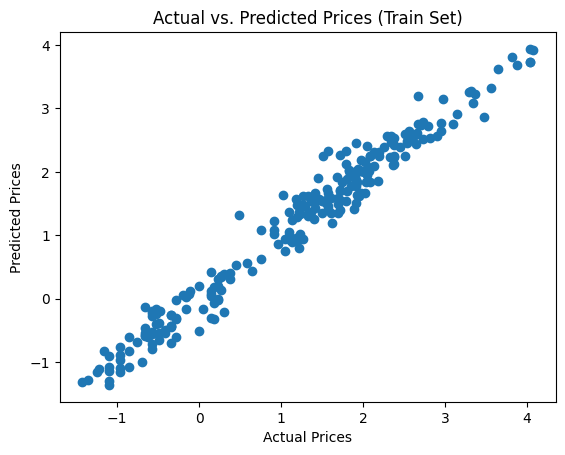

In [46]:
# 1.Linearity Assumption
plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices (Train Set)")
plt.show()

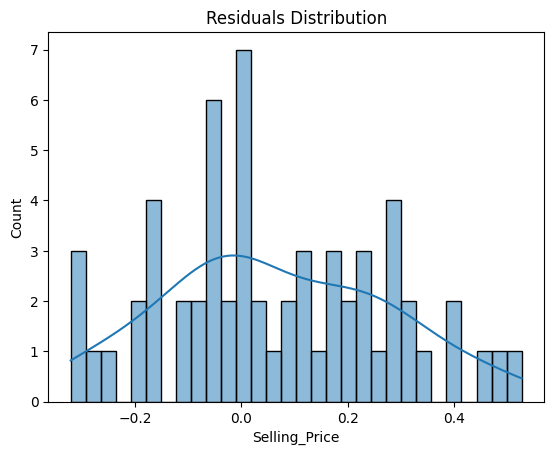

In [47]:
# 2.Normality of Residuals
residuals = y_test - y_test_pred
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.show()

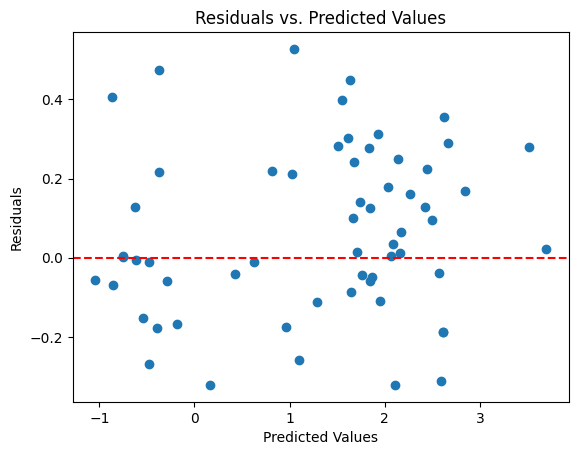

In [48]:
# 3.Homoscedasticity (Constant Variance of Residuals)
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

In [49]:
# 4.Multicollinearity Check (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
                  Feature       VIF
0           Present_Price  4.747304
1              Kms_Driven  2.471411
2                   Owner  1.053254
3        Fuel_Type_Diesel  1.366566
4  Seller_Type_Individual  3.668890
5     Transmission_Manual  1.196123
6                 Car_Age  1.960474


In [50]:
# 5.No Autocorrelation (Durbin-Watson Test)
dw_test = durbin_watson(residuals)
print("Durbin-Watson Test Statistic:", dw_test)

Durbin-Watson Test Statistic: 1.913809250055458


#### After transformation, we can see all assumptions are satisfied

## Save final features, final model, Box-Cox Lambda Values and Feature Scaler to be used in new unseen data

In [51]:
# Save final features used in model
with open("feature_list.json", "w") as f:
    json.dump(list(X_train.columns), f)

# Save final model
joblib.dump(lr, 'final_model_lr.joblib')

# Save Box-Cox Lambda Values (to transform future data correctly)
joblib.dump(fitted_lambda, "boxcox_lambda_values.joblib")

# Save Feature Scaler
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

## Feature Importance

In [52]:
# Get feature importance (coefficients)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': lr.coef_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

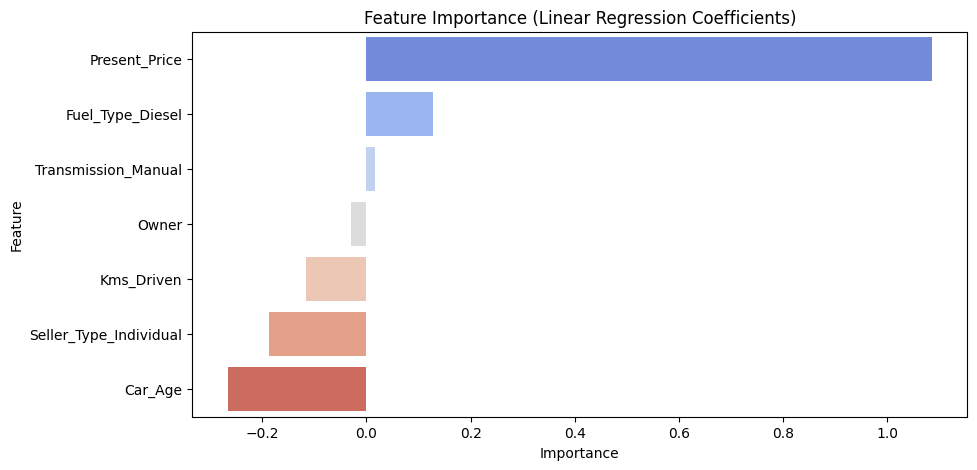

In [53]:
# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.show()

# Final Interpretation of the Model  

## Key Takeaways from Feature Importance (Linear Regression Coefficients)  

### 1. Present Price (**Strongest Positive Impact**)  
- **Most influential factor** in determining the selling price.  
- A **higher original price** significantly increases resale value.  
- Premium cars **retain more value** over time.  

### 2. Fuel Type - Diesel (**Moderate Positive Impact**)  
- **Diesel cars** have a **higher resale value** than petrol or other fuel types.  
- Diesel engines are **more fuel-efficient** and **longer-lasting**, making them desirable in the used car market.  

### 3. Transmission - Manual (**Minimal Positive Impact**)  
- Manual transmission has a **small positive effect** on price, but the impact is almost negligible.  
- This suggests that **transmission type is not a key factor** in resale value.  

### 4. Owner (**Minimal Negative Impact**)  
- **More previous owners lead to a slightly lower resale price.**  
- Buyers may prefer **fewer past owners** due to concerns over wear and maintenance history.  
- The impact is **small** but noticeable.  

### 5. Kms Driven (**Negative Impact**)  
- The number of kilometers driven **reduces the resale price**.  
- Higher mileage **suggests more wear and tear**, leading to lower demand in the second-hand market.  

### 6. Seller Type - Individual (**Moderate Negative Impact**)  
- Cars sold by **individual sellers** tend to have **lower resale prices** compared to dealership sales.  
- Dealers may offer **warranties and better service**, making their cars more attractive and commanding a higher price.  

### 7. Car Age (**Strongest Negative Impact**)  
- **Older cars lose value significantly**, making it the **strongest negative factor**.  
- Depreciation, lack of modern features, and higher maintenance costs contribute to this decline.  

---

## Conclusion  
- **Present Price is the strongest positive predictor**, meaning newer and more expensive cars hold better resale value.  
- **Diesel cars** sell at a higher price due to durability and efficiency.  
- **Car Age and Kms Driven** are **key factors lowering resale value**, highlighting the importance of depreciation.  
- **Seller Type, Ownership history, and Transmission have moderate effects**, with individual sellers and higher ownership count leading to slightly lower resale values.  
